In [2]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np



In [74]:
import hytools as ht
import numpy as np
envi = ht.HyTools()
envi.read_file("export/resampled_for_landsat",'envi')
rowrange = np.arange(1, 6000, 6).tolist()
colrange = np.arange(0, 1000, 1).tolist()

original = envi.get_pixels(rowrange, colrange)


In [76]:
import hytools as ht
import numpy as np

def get_spectral_data(filename, row_step, col_step):
    """
    Retrieve spectral data from a specified file using HyTools library.

    Parameters:
    - filename: str, the path to the file to be read.
    - row_step: int, the step size to sample rows by.
    - col_step: int, the step size to sample columns by.

    Returns:
    - original: np.ndarray, a 2D array where each row corresponds to the spectral data from one pixel.
    """
    # Initialize the HyTools object
    envi = ht.HyTools()
    
    # Read the file using the specified format
    envi.read_file(filename, 'envi')
    
    # Define the row and column ranges
    rowrange = np.arange(1, round(envi.lines,-3), row_step).tolist() # Adjusted to use envi.lines for dynamic range
    colrange = np.arange(0, round(envi.columns,-3), col_step).tolist() # Adjusted to use envi.columns for dynamic range
    
    # Retrieve the pixels' spectral data
    original = envi.get_pixels(rowrange, colrange)
    
    return original

# Example usage
filename = "export/resampled_for_landsat"
row_step = 6
col_step = 1
spectral_data = get_spectral_data(filename, row_step, col_step)
spectral_data


array([[-9998.99999999, -9999.        , -9999.        , -9999.        ,
        -9999.        , -9998.99935073],
       [-9998.99999999, -9999.        , -9999.        , -9999.        ,
        -9999.        , -9998.99935073],
       [-9998.99999999, -9999.        , -9999.        , -9999.        ,
        -9999.        , -9998.99935073],
       ...,
       [-9998.99999999, -9999.        , -9999.        , -9999.        ,
        -9999.        , -9998.99935073],
       [-9998.99999999, -9999.        , -9999.        , -9999.        ,
        -9999.        , -9998.99935073],
       [-9998.99999999, -9999.        , -9999.        , -9999.        ,
        -9999.        , -9998.99935073]])

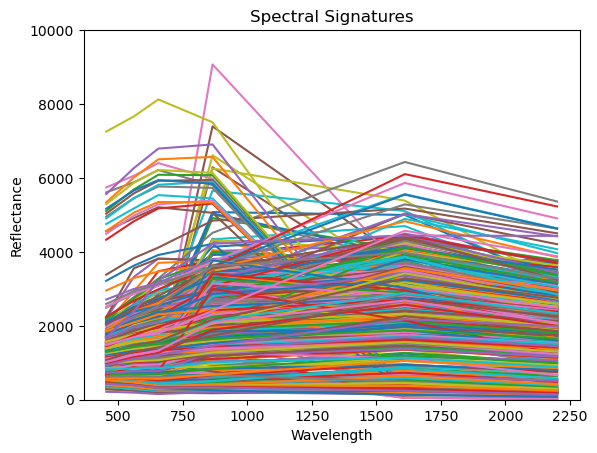

In [77]:

for i in range(spectral_data.shape[0]): # Loop through each row/pixel
    plt.plot(envi.wavelengths, spectral_data[i, :], label=f'Pixel {i+1}')

plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.title('Spectral Signatures')
plt.ylim(0,10000)
plt.show()

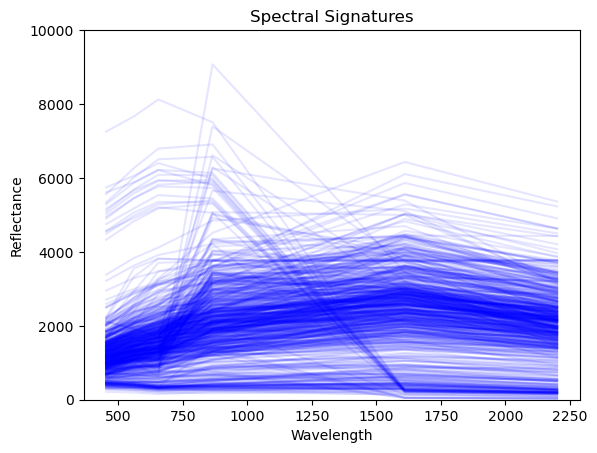

In [82]:
import matplotlib.pyplot as plt

def plot_spectral_signatures(wavelengths, spectral_data, line_color='blue', transparency=0.1):
    """
    Plot spectral signatures for each pixel in the spectral data, all in the same specified color and with transparency.

    Parameters:
    - wavelengths: array-like, the wavelengths corresponding to the spectral bands.
    - spectral_data: 2D array, spectral data where each row corresponds to a pixel and columns to spectral bands.
    - line_color: str, optional, the color of the lines. Default is 'blue'.
    - transparency: float, optional, the transparency level of the lines. Default is 0.5.
    """
    # Check if spectral_data is not empty
    if spectral_data.size == 0:
        print("Spectral data is empty.")
        return

    # Plotting each pixel's spectral signature
    for i in range(spectral_data.shape[0]):  # Loop through each row/pixel
        plt.plot(wavelengths, spectral_data[i, :], color=line_color, alpha=transparency)
    
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.title('Spectral Signatures')
    plt.ylim(0, 10000)
    plt.show()


# Example usage (assuming envi.wavelengths and spectral_data are already defined):
plot_spectral_signatures(envi.wavelengths, spectral_data)


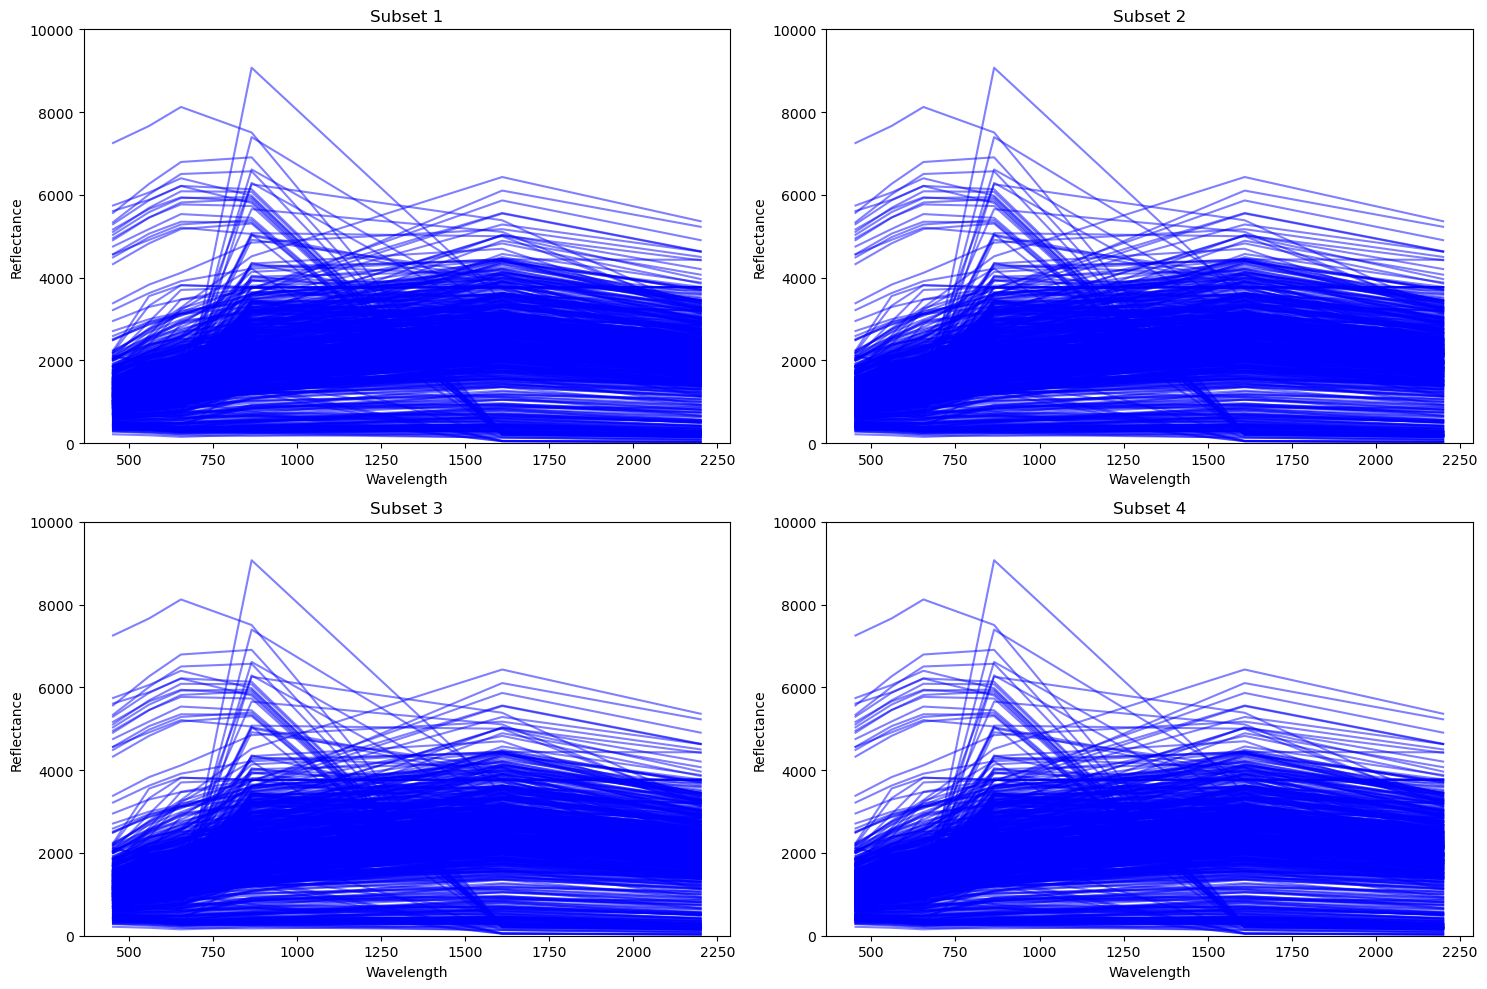

In [86]:
import matplotlib.pyplot as plt

def plot_spectral_signature_subplot(wavelengths, spectral_data_sets, line_color='blue', transparency=0.01, nrows=2, ncols=2):
    """
    Plot a panel of spectral signatures for different subsets of spectral data.

    Parameters:
    - wavelengths: array-like, the wavelengths corresponding to the spectral bands.
    - spectral_data_sets: list of 2D arrays, each element in the list is spectral data for a subplot.
    - line_color: str, optional, the color of the lines. Default is 'blue'.
    - transparency: float, optional, the transparency level of the lines. Default is 0.5.
    - nrows: int, number of rows in the subplot grid.
    - ncols: int, number of columns in the subplot grid.
    """
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 10))  # Adjust figsize as needed
    axs = axs.flatten()  # Flatten the array of axes if more than one row or column

    for idx, data in enumerate(spectral_data_sets):
        ax = axs[idx]
        for i in range(data.shape[0]):
            ax.plot(wavelengths, data[i, :], color=line_color, alpha=transparency)
        ax.set_ylim(0, 10000)
        ax.set_title(f'Subset {idx+1}')
        ax.set_xlabel('Wavelength')
        ax.set_ylabel('Reflectance')

    # Hide any unused subplots
    for ax in axs[len(spectral_data_sets):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a list of different spectral_data arrays to plot
plot_spectral_signature_subplot(envi.wavelengths, [spectral_data, spectral_data, spectral_data, spectral_data], 'blue', 0.5, nrows=2, ncols=2)
